In [ ]:
# If you are using colab, you can mount your google drive and access data from there
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing
We interpolate then normalize the data. Each is done individually

In [ ]:
# Replace with your own files
!cp "/content/drive/My Drive/ramandata/conor/Train_Inputs.mat" .
!cp "/content/drive/My Drive/ramandata/conor/Test_Inputs.mat" .

In [ ]:
import scipy.io
import numpy as np

input_data = scipy.io.loadmat('Train_Inputs.mat')
input_data1 = scipy.io.loadmat('Test_Inputs.mat')

print(input_data)

# Only use train data
training_data = input_data['Train_Inputs']

print("TRAINING DATA SHAPE")
print(training_data.shape)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Jun 19 09:30:13 2020', '__version__': '1.0', '__globals__': [], 'Train_Inputs': array([[7.86813014e-07, 6.69546402e-02, 5.07179669e-03, ...,
        7.72721193e-02, 2.56721350e-02, 3.85286597e-02],
       [1.34920635e-01, 1.42857143e-01, 1.03174603e-01, ...,
        3.17460317e-02, 3.96825397e-02, 2.38095238e-02],
       [7.24392543e-07, 4.49166840e-02, 7.24392543e-07, ...,
        4.36772484e-02, 3.19580258e-02, 3.21079751e-02],
       ...,
       [1.13636364e-01, 8.33333333e-02, 1.21212121e-01, ...,
        3.03030303e-02, 2.27272727e-02, 3.03030303e-02],
       [5.94862057e-07, 5.94862057e-07, 2.09022630e-02, ...,
        3.62419708e-02, 1.66020052e-02, 4.56949238e-02],
       [0.00000000e+00, 0.00000000e+00, 6.95627289e-02, ...,
        1.73816729e-02, 2.60709194e-02, 2.60635000e-02]])}
TRAINING DATA SHAPE
(159618, 500)


In [ ]:
def read_axis(filename):
    """Read the wavelength axis from file."""
    with open(filename, 'r') as f:
        wavelengths = np.array([float(line.strip()) for line in f])
    return wavelengths

wavelengths = read_axis("/content/drive/My Drive/ramandata/conor/axis.txt")

In [ ]:
from scipy import interpolate
from tqdm import tqdm

def interpolate_spectra(spectra_data, old_wavelengths, new_points=1000):
    # Create new wavelength points (evenly spaced)
    new_wavelengths = np.linspace(
        old_wavelengths[0],
        old_wavelengths[-1],
        new_points
    )

    # Initialize array for interpolated spectra
    interpolated_spectra = np.zeros((spectra_data.shape[0], new_points))

    # Interpolate each spectrum
    for i in tqdm(range(spectra_data.shape[0])):
        # Create cubic spline interpolation function
        f = interpolate.CubicSpline(old_wavelengths, spectra_data[i, :])

        # Apply interpolation to new wavelength points
        interpolated_spectra[i, :] = f(new_wavelengths)

    return interpolated_spectra, new_wavelengths

In [ ]:
def normalize_raman_spectra(spectra):
    # Create output array
    normalized = np.zeros_like(spectra)

    # Normalize each spectrum individually
    for i in tqdm(range(spectra.shape[0])):
        spectrum = spectra[i, :]
        min_val = np.min(spectrum)
        max_val = np.max(spectrum)

        # Min-max normalization to [0,1] range
        normalized[i, :] = (spectrum - min_val) / (max_val - min_val)

    return normalized

In [ ]:
interpolated_spectra, new_wavelengths = interpolate_spectra(
    training_data,
    wavelengths,
    new_points=1000
)

100%|██████████| 159618/159618 [01:06<00:00, 2383.04it/s]


In [ ]:
normalized_spectra = normalize_raman_spectra(interpolated_spectra)
normalized_spectra.shape

100%|██████████| 159618/159618 [00:02<00:00, 60243.08it/s]


In [ ]:
# Replace with your own file
np.savez('/content/drive/My Drive/repl_normalized_spectra_breastcancer_train_only_1_4.npz',
          spectra=normalized_spectra,
          wavelengths=wavelengths)

# Plot Comparison
These plots are used in Several figures throughout the RamanFoundation paper

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('default')

FONTSIZE_AXIS = 15
FONTSIZE_TITLE=15

In [ ]:
# Helpers
def get_spectra_from_range(spectra, wavelengths, wavelength_range):
  # Find indices of wavelengths within the range
  indices = np.where((wavelengths >= wavelength_range[0]) &
                     (wavelengths <= wavelength_range[1]))[0]

  # Extract the corresponding spectra
  extracted_spectra = spectra[indices]
  extracted_wavelengths = wavelengths[indices]

  return extracted_wavelengths, extracted_spectra

This plot is used to provide an example of interpolation in Figure 3

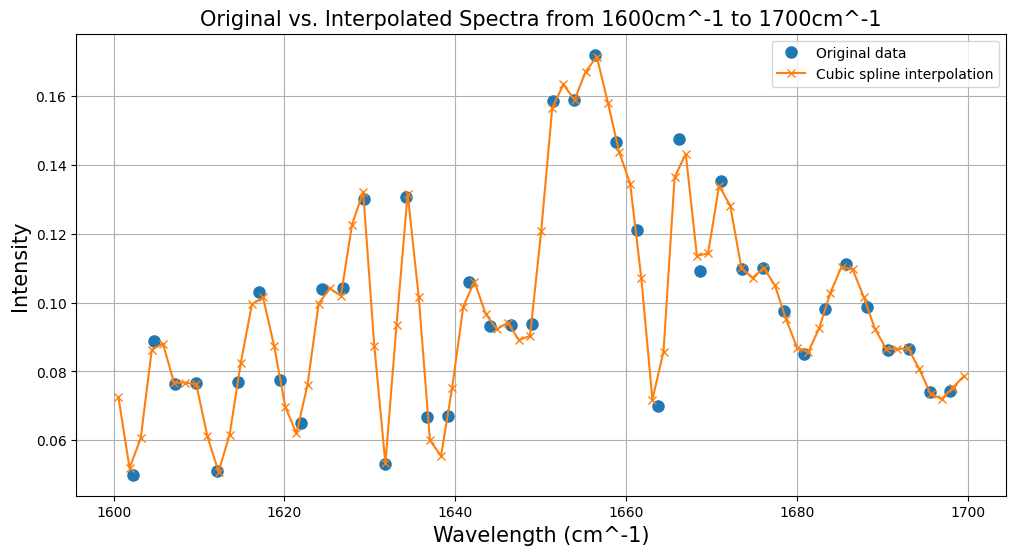

In [ ]:
wavelength_range = (1600, 1700)
sample_idx = 0

training_sample = training_data[sample_idx]
interpolated_sample = interpolated_spectra[sample_idx]

wavelengths_original, spectra_original = get_spectra_from_range(training_sample, wavelengths, wavelength_range)
wavelengths_interpolated, spectra_interpolated = get_spectra_from_range(interpolated_sample, new_wavelengths, wavelength_range)

plt.figure(figsize=(12,6))
plt.plot(wavelengths_original, spectra_original,
        'o', label='Original data', markersize=8)
plt.plot(wavelengths_interpolated, spectra_interpolated,
          'x-', label='Cubic spline interpolation')

plt.xlabel('Wavelength (cm^-1)', fontsize=FONTSIZE_AXIS)
plt.ylabel('Intensity', fontsize=FONTSIZE_AXIS)
plt.title(f'Original vs. Interpolated Spectra from {wavelength_range[0]}cm^-1 to {wavelength_range[1]}cm^-1', fontsize=FONTSIZE_TITLE)
plt.legend()
plt.grid(True)
plt.show()

This plot is used to show normalization in Figure 3

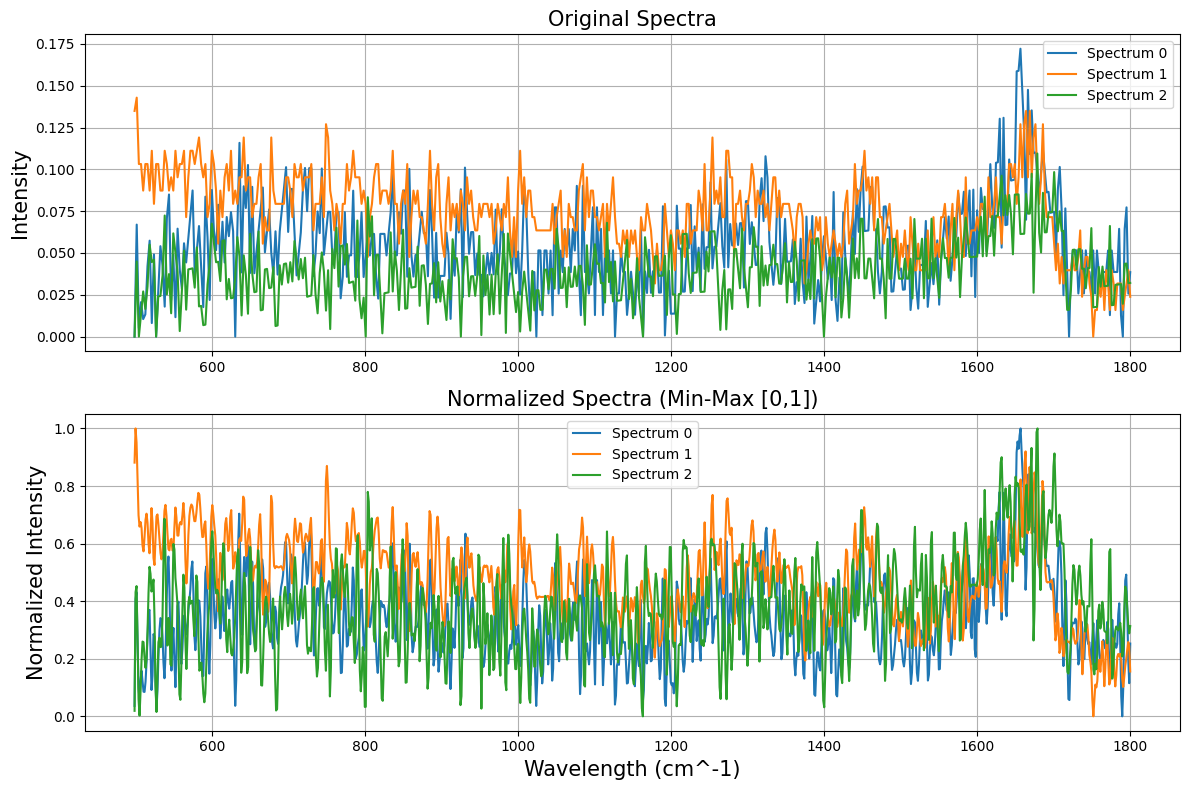

In [ ]:
def plot_normalization_comparison(original_spectra, normalized_spectra, sample_indices=[0,1,2]):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Plot original spectra
    for idx in sample_indices:
        ax1.plot(wavelengths, original_spectra[idx], label=f'Spectrum {idx}')
    ax1.set_title('Original Spectra', fontsize=FONTSIZE_TITLE)
    # ax1.set_xlabel('Wavelength (cm^-1)', fontsize=FONTSIZE_AXIS)
    ax1.set_ylabel('Intensity', fontsize=FONTSIZE_AXIS)
    ax1.legend()
    ax1.grid(True)

    # Plot normalized spectra
    for idx in sample_indices:
        ax2.plot(new_wavelengths, normalized_spectra[idx], label=f'Spectrum {idx}')
    ax2.set_title('Normalized Spectra (Min-Max [0,1])', fontsize=FONTSIZE_TITLE)
    ax2.set_xlabel('Wavelength (cm^-1)', fontsize=FONTSIZE_AXIS)
    ax2.set_ylabel('Normalized Intensity', fontsize=FONTSIZE_AXIS)
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


# Plot comparison
plot_normalization_comparison(training_data, normalized_spectra)